<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/polyhedron-gdl/applied-computational-finance/blob/master/2021/1_notebooks/lesson_3_finite_difference_option_pricing.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Finite Difference Methods for Heston PDE  

In [10]:
%matplotlib inline


import math
import numpy             as np
import pandas            as pd
import scipy.stats       as ss
import matplotlib
import pylab

from pylab import *
from matplotlib import pyplot as pl

## Introduction

In this notebook, we present methods to obtain the European call price by solving the Heston PDE along a two-dimensional grid representing the stock price and the volatility. We first show how to construct uniform and nonuniform grids for the
discretization of the stock price and the volatility, and present formulas for finite difference approximations to the derivatives in the Heston PDE.

As you alredy known, one of the limitations of using the famous Black-Scholes model is the assumption of a constant volatility $\sigma$. A major modeling step away from the assumption of constant volatility in asset pricing, was made by modeling the volatility/variance as a diffusion process. The resulting models are the stochastic volatility (SV) models. The idea to model volatility as a random variable is confirmed by practical financial data which indicates the variable and unpredictable nature of the stock price’s volatility. The most significant argument to consider the volatility to be stochastic is the implied volatility smile/skew, which is present in the financial market data, and can be accurately recovered by SV models, especially
for options with a medium to long time to the maturity date T. With an additional stochastic process, which is correlated to the asset price process St, we deal with a system of SDEs, for which option valuation is more expensive than for a scalar asset price process.

The most popular SV model is the Heston model, for which the system of stochastic equations under the risk-neural measure reads:

$$
dS_t = rS_t dt + \sqrt{v_t} S_t dZ_t^1
$$

with the variance following the square-root diffusion

$$
dv_t = \kappa_v (\theta_v - v_t) dt + \sigma_v \sqrt{v_t} dZ_t^2
$$

The two Brownian motions are instantaneously correlated with $dZ_t^1 dZ_t^2 = \rho$. The second equation models a mean reversion process for the variance, with the parameters, $r$ the risk-free interest rate, $\theta_v$ the long term variance, $\kappa_v$ the reversion speed; $\sigma_v$ is the volatility of the variance,
determining the volatility of $v_t$. There is an additional parameter $v_0$, the $t_0$-value of the variance.




### The Heston PDE

The Heston partial differential equation (PDE) for the value $U(S,,v,t)$ of an option on a dividend-paying stock, when the spot price is $S$, the volatility is $v$ and the maturity is $t$, is

\begin{equation}
    \frac{\partial U}{\partial t} = \frac{1}{2}v S^2 \frac{\partial^2 U}{\partial S^2} +
    \rho \sigma v S \frac{\partial^2 U}{\partial v \partial S} + \frac{1}{2} \sigma^2 v  \frac{\partial^2 U}{\partial v^2}
    -rU + (r-q)S \frac{\partial U}{\partial S} + \kappa(\theta-v)\frac{\partial U}{\partial v}
\end{equation}

In a compact notation, we can express the PDE as

\begin{equation}
      \frac{\partial U}{\partial t} = LU(t)
\end{equation}

As we have already seen, to implement finite differences, we first need a discretization grid for the
**two state variables (the stock price and the variance)**, and a discretization grid for the
maturity. These grids can have equally or unequally spaced increments. Second, we
need **discrete approximations to the continuous derivatives** that appear in the PDE.
Finally, we need a **finite difference methodology** to solve the PDE.

**See Lecture Notes for the derivation of the Heston PDE**

## How to check the PDE solution?

As we have already said, it is extremely important to have procedures for verifying and controlling the developed algorithms. For this reason we will now develop a simple Python code to calculate the price of a European option in the Heston model by implementing the well-known semi-analytical solution.

The time-$t$ price of a European call on a non-dividend-paying stock with spot price $S_t$, when the strike is $K$ and the time
to maturity is $\tau = T − t$ in the Heston Model can be written as:

\begin{equation}
C(K) = S_t P_1 - Ke^{-r\tau}P_2
\end{equation}

where $P_1$ and $P_2$ are two probabilities under two different measures:

\begin{equation}
C(K) = S_t \mathbb{Q}^S(S_T >K) - Ke^{-r\tau}\mathbb{Q}(S_T >K)
\end{equation}

The measure $\mathbb{Q}$ uses the bond $B_t$ as the numeraire, while the measure $\mathbb{Q}^S$ uses the stock price $S_t$.


### Calculation of Probability for Heston Model

In the Heston model, it can be shown that $P_1$ and $P_2$ can be written as:

\begin{equation}
P_j = \text{Pr}_j \left( \ln S_T - \ln K \right) = \frac{1}{2} + \frac{1}{\pi} \int\limits_0^\infty
\text{Re} \left[
\frac{e^{-i\phi \ln K}f_j(\phi;x,v)}{i\phi}
\right]\, d\phi
\end{equation}

Heston postulates that these characteristic functions are of the log linear form

\begin{equation}
f_j(\phi;x_t,v_t) =\exp \left( C_j(\tau, \phi) + D_j (\tau, \phi) v_t + i \phi x_t \right) 
\end{equation}

where $C_j$ and $D_j$ are constant coefficients and $\tau = T-t$ is the time to maturity. The coefficients can be shown to be

\begin{equation}
D_j(\tau, \phi) = \frac{b_j - \rho \sigma i \phi + d_j}{\sigma^2} 
\left(
\frac{1-e^{d_j\tau}}{1-g_je^{d_j\tau}}
\right)
\end{equation}

and

\begin{equation}
C_j (\tau, \phi) = ri\phi \tau + \frac{a}{\sigma^2}
\left[
(b_j - \rho \sigma i \phi + d_j)\tau - 2\ln \left(
\frac{1-g_je^{d_j\tau}}{1-g_j}
\right)
\right]
\end{equation}

where $a = \kappa \theta$ and 

\begin{equation}
d_j = \sqrt{(\rho \sigma i \phi - b_j)^2 - \sigma^2(2u_j i \phi - \phi^2)}
\end{equation}

\begin{equation}
g_j = \frac{b_j - \rho \sigma i \phi + d_j}{b_j - \rho \sigma i \phi - d_j}
\end{equation}

and with

\begin{equation}
u_1 = \frac{1}{2} \quad u_2 = -\frac{1}{2} 
\end{equation}

\begin{equation}
b_1 = \kappa + \lambda - \rho \sigma \quad b_2 = \kappa + \lambda 
\end{equation}

We will use two functions to implement the Heston call price using the *trapezoidal rule* to solve the integral: *HestonProb* and *HestonPriceTrapz*. The first function calculates the characteristic functions and returns the real part of the integral. Since this is the most complicated calculation, we are going to describe all the single steps befor collect all into the single block function. First of all we define model and option parameters:

In [11]:
'''
Model Parameters

Heston parameters:
    kappa  = volatility mean reversion speed parameter
    theta  = volatility mean reversion level parameter
    lambda = risk parameter
    rho    = correlation between two Brownian motions
    sigma  = volatility of variance
    v0     = initial variance
    
    phi    = integration variable
    Pnum   = 1 or 2 (for the probabilities)
'''
kappa  = 1.5  
theta  = 0.04 
sigma  = 0.3 
rho    = 1 
lambd  = 0.0 
v0     = 0.05412 

Pnum   = 1
phi    = 0.00000001
'''
Option features

    K = strike price
    tau = maturity
    r = risk free rate
    q = dividend yield
    S = spot price
'''
K      = 100.0 
tau    = 0.15 
r      = 0.02 
q      = 0.05 
S      = 101.52 

In [12]:
import math
import cmath

x = math.log(S)
a = kappa*theta
# Parameters "u" and "b" are different for P1 and P2 (see equations 7 and 8).
if(Pnum == 1):
    u = 0.5
    b = kappa + lambd - rho * sigma
else:
    u = -0.5
    b = kappa + lambd


Now we can start calculating the factors: $i \rho\sigma \phi$, $2ui \phi$ and $i \phi \tau$  

In [13]:
rhosigmaphi = complex(0, rho * sigma * phi)
twouphi     = complex(0, 2 * u * phi)
phitaui     = complex(0, phi * tau)

one         = complex(1, 0)
two         = complex(2, 0)

which can be used to calculate:

\begin{equation}
d_j = \sqrt{(\rho \sigma i \phi - b_j)^2 - \sigma^2(2u_j i \phi - \phi^2)}
\end{equation}

In [14]:
d1 = (rhosigmaphi - complex(b, 0))**2
d2 = (twouphi     - complex(phi * phi, 0)) * complex(sigma*sigma, 0)
d  = cmath.sqrt(d1 - d2)
d

(1.2-3.375e-09j)

and ...

\begin{equation}
g_j = \frac{b_j - \rho \sigma i \phi + d_j}{b_j - \rho \sigma i \phi - d_j}
\end{equation}

In [15]:
g = (complex(b, 0) - rhosigmaphi + d)/(complex(b, 0) - rhosigmaphi - d)
g

(-16.999999999999996-6399999999.999999j)

Now we compute the ratio ...

\begin{equation}
\frac{1-g_je^{d_j\tau}}{1-g_j}
\end{equation}

In [16]:
BigG = (one - g*cmath.exp(d*complex(tau, 0)))/(one - g)
BigG

(1.1972173631218102-5.752760770926336e-10j)

... and finally we can calculate $C_j$:

\begin{equation}
C_j (\tau, \phi) = (r-q)i\phi \tau + \frac{a}{\sigma^2}
\left[
(b_j - \rho \sigma i \phi + d_j)\tau - 2\ln \left(
\frac{1-g_je^{d_j\tau}}{1-g_j}
\right)
\right]
\end{equation}

In [17]:
term2 = (complex(b, 0) - rhosigmaphi + d)
term3 = complex(r - q, 0) * phitaui
c1    = complex(tau, 0) * term2
c2    = two * cmath.log(BigG)
c3    = c1 - c2
term4 = complex(a/sigma**2, 0) * c3
bigC  = term3 + term4
bigC

-4.181870595598485e-11j

... and $D_j$:

\begin{equation}
D_j(\tau, \phi) = \frac{b_j - \rho \sigma i \phi + d_j}{\sigma^2} 
\left(
\frac{1-e^{d_j\tau}}{1-g_je^{d_j\tau}}
\right)
\end{equation}

In [18]:
# (bj - i*rho*sigma*phi + dj) is term2
term5 = term2/complex(sigma * sigma, 0)
b1    = cmath.exp(d*complex(tau, 0))
term6 = (one - b1)/(one - g*b1)
bigD  = term5*term6
bigD

(1.6723187497605994e-18+6.863741191196999e-10j)

Now we can calculate the *characteristic function*:

\begin{equation}
f_j(\phi; x_t, v_t) = \exp \left( C_j(\tau, \phi) + D_j(\tau, \phi)v_t + i\phi x_t \right)
\end{equation}

In [19]:
# characteristic function

phixi = complex(0, phi * x)
f     = cmath.exp(bigC + bigD * complex(v0, 0) + phixi)
f

(0.9999999999999989+4.619788609543208e-08j)

and the integrand in the formula for probability:

\begin{equation}
\text{Re} \left[
\frac{e^{-i\phi \ln K}f_j(\phi;x,v)}{i\phi}
\right]\
\end{equation}

In [20]:
philogKi   = complex(0, -math.log(K) * phi)
e1         = cmath.exp(philogKi)
e2         = e1 * f
E          = e2/complex(0, phi)
HestonProb = E.real
HestonProb

0.014618423555117976

### Probability Density Function

Below we simply put all the pieces together in a single function:

In [21]:
def HestonProb(phi,kappa,theta,lambd,rho,sigma,tau,K,S,r,q,v0,Pnum):
    
    x      = math.log(S)

    a = kappa*theta
    # Parameters "u" and "b" are different for P1 and P2.
    if(Pnum == 1):
        u = 0.5
        b = kappa + lambd - rho * sigma
    else:
        u = -0.5
        b = kappa + lambd
    
    rhosigmaphi = complex(0, rho * sigma * phi)
    twouphi     = complex(0, 2 * u * phi)
    phitaui     = complex(0, phi * tau)

    d1   = (rhosigmaphi - complex(b, 0))**2
    d2   = (twouphi     - complex(phi * phi, 0)) * complex(sigma*sigma, 0)
    d    = cmath.sqrt(d1 - d2)

    g    = (complex(b, 0) - rhosigmaphi + d)/(complex(b, 0) - rhosigmaphi - d)
    BigG = (1 - g*cmath.exp(d*complex(tau, 0)))/(1 - g)

    term2 = (complex(b, 0) - rhosigmaphi + d)
    term3 = complex(r - q, 0) * phitaui
    c1    = complex(tau, 0) * term2
    c2    = 2 * cmath.log(BigG)
    c3    = c1 - c2
    term4 = complex(a/sigma**2, 0) * c3
    bigC  = term3 + term4
    
    term5 = term2/complex(sigma * sigma, 0)
    b1    = cmath.exp(d*complex(tau, 0))
    term6 = (1 - b1)/(1 - g*b1)
    bigD  = term5*term6

    dv0   = bigD * complex(v0, 0)
    phixi = complex(0, phi * x)
    f     = cmath.exp(bigC + dv0 + phixi)

    philogKi   = complex(0, -math.log(K) * phi)
    e1         = cmath.exp(philogKi)
    e2         = e1 * f
    E          = e2/complex(0, phi)
    HestonProb = E.real

    return HestonProb

In [22]:
print(HestonProb(phi,kappa,theta,lambd,rho,sigma,tau,K,S,r,q,v0,Pnum))

0.014618423555117976


## Pricing an European Call Option

\begin{equation}
C(K)= S_t P_1 - K e^{-r\tau}P_2
\end{equation}

In [23]:
def HestonPriceTrapz(PutCall,kappa,theta,lambd,rho,sigma,T,K,S,r,q,v0,trap,Lphi,Uphi,N):
    '''
    ' Heston (1993) price of a European option.
    ' Uses the original formulation by Heston
    ' Heston parameters:
    '    kappa  = volatility mean reversion speed parameter
    '    theta  = volatility mean reversion level parameter
    '    lambda = risk parameter
    '    rho    = correlation between two Brownian motions
    '    sigma  = volatility of variance
    '    v0     = initial variance
    ' Option features.
    '    PutCall = 'C'all or 'P'ut
    '    K = strike price
    '    S = spot price
    '    r = risk free rate
    '    q = dividend yield
    '    T = maturity
    ' Integration features
    '    Lphi = lower limit
    '    Uphi = upper limit
    '    N    = Number of grid points
    '''        

In [24]:
    N = 500
    T = tau
    
    Lphi = 0.00000001
    Uphi = 150

    dphi = (Uphi - Lphi) / (N - 1)
    phi  = np.arange(Lphi, Uphi+dphi, dphi)
    
    # Weights for trapezoidal rule
    W = np.full(N, dphi)
    W[0] = W[N-1] = 0.5*dphi
    
    int1 = np.array([HestonProb(ph, kappa, theta, lambd, rho, sigma, T, K, S, r, q, v0, 1) for ph in phi])*W
    int2 = np.array([HestonProb(ph, kappa, theta, lambd, rho, sigma, T, K, S, r, q, v0, 2) for ph in phi])*W
    
    I1 = np.sum(int1)
    I2 = np.sum(int2)
    
    P1 = 0.5 + 1 / np.pi * I1
    P2 = 0.5 + 1 / np.pi * I2

    # The call price
    HestonC = S * math.exp(-q * T) * P1 - K * math.exp(-r * T) * P2

    # The put price by put-call parity
    HestonP = HestonC - S * math.exp(-q * T) + K * math.exp(-r * T)


In [25]:
print('Call price : ' + str(HestonC))
print('Put  price : ' + str(HestonP))

Call price : 4.0490387831701184
Put  price : 2.9880402082684867


Of course we could have used directly the 'trapz' method of Numpy library. Below the simple code to obtain the same result as above...

In [26]:
    y1 = np.array([HestonProb(ph, kappa, theta, lambd, rho, sigma, T, K, S, r, q, v0, 1) for ph in phi])
    y2 = np.array([HestonProb(ph, kappa, theta, lambd, rho, sigma, T, K, S, r, q, v0, 2) for ph in phi])
    
    # call trapz method of numply
    I1np = np.trapz(y1, phi)
    I2np = np.trapz(y2, phi)

    P1np = 0.5 + 1 / np.pi * I1np
    P2np = 0.5 + 1 / np.pi * I2np

    # The call price
    HestonC2 = S * math.exp(-q * T) * P1np - K * math.exp(-r * T) * P2np

    # The put price by put-call parity
    HestonP2 = HestonC - S * math.exp(-q * T) + K * math.exp(-r * T)


In [27]:
print('Call price : ' + str(HestonC2))
print('Put  price : ' + str(HestonP2))

Call price : 4.0490387831701184
Put  price : 2.9880402082684867


## Finite Differences for Heston Model

Now, having a challenge algorithm, we can start to work on the main problem of this lesson: the solution of the Heston PDE equation in Two Dimension with Finite Difference Method. We first show how to construct uniform and nonuniform grids for the discretization of the stock price and the volatility, and present formulas for finite difference approximations to the derivatives in the Heston PDE. Next, we explain the boundary conditions of the PDE for a European call and then we will implement an Explicit scheme.

### Explicit Scheme

In [28]:
# Heston Parameters
params = (kappa, theta, sigma, v0, rho, lambd)

In [29]:
# Boundary Values for Stock Price, Volatility, and Maturity

Smin = 0.0000
Smax = 2 * K
Vmin = 0 
Vmax = 0.5
Tmin = 0
Tmax = 0.15

# Number of Steps in Each Dimension

NS = 30
NV = 30
NT = 1500

In [30]:
# Option Features
Strike = K

In [31]:
'''
' Finite differences for the Heston PDE for a European Call
' Reference:
' In 'T Hout and Foulon "ADI Finite Difference Schemes for Option Pricing in the Heston Model with Correlation" 
' Int J of Num Analysis and Modeling, 2010.
' INPUTS
'    params     = 6x1 vector of Heston parameters
'    Strike     = Strike price
'    r          = risk free rate
'    q          = Dividend yield
'    Smax, Smin = Max and Min values of stock price
'    Vmax, Vmin = Max and Min values of volatility
'    Tmax, Tmin = Max and Min values of maturity
'    NS, NV, NT = Number of points on stock price, volatility, and maturity grids
'    GridType   = Type of Grid ("Uniform" or "NonUniform")
'    Si         = Value of Spot price at which to interpolate on U(S,V)
'    Vi         = Value of Volatility at which to interpolate on U(S,V)
' OUTPUT
'    U(Si,Vi)   = Interpolated value of U(S,V) and points (Si,Vi)
'''
# Heston parameters. Note: only kappa, theta, and sigma are needed
kappa = params[0]
theta = params[1]
sigma = params[2]

# Increment for Stock Price, Volatility, and Maturity
ds = (Smax - Smin) / (NS - 1)
dv = (Vmax - Vmin) / (NV - 1)
dt = (Tmax - Tmin) / (NT - 1)

print(ds, dv, dt)

6.896551724137931 0.017241379310344827 0.00010006671114076051


### Building Grid

Uniform grids are those that have equally spaced increments for the two state
variables. These grids have two advantages: first, they are easy to construct, and
second, since the increments are equal, the finite difference approximations to
the derivatives in the PDE take on a simple form. Non-uniform grids are more
complicated to construct, and the finite difference approximations to the derivatives
are more complicated. These grids, however, can be made finer around
certain points, in particular, around the region $(S, v) = (K, 0)$ where option prices
are often required. Hence, non-uniform grids are often preferable since they produce
more accurate prices with fewer grid points, and consequently, with less
computation time.

#### Building a Uniform Grid

We denote the maximum values of $S$, $v$, and $t$ as $Smax$, $Vmax$ and $Tmax = \tau$ (the maturity), and the minimum values as $Smin$, $Vmin$, and $Tmin= 0$. We denote by $U^n_{i, j}= U(S_i, v_j, t_n)$ the value of an option at time $t_n$ when the stock price is $S_i$ and the volatility is $v_j$. We use $NS+ 1$ points for the stock price, $NV+ 1$ points for the volatility, and $NT+ 1$ points for the maturity. For convenience, sometimes we write simply $U(S_i, v_j)$ for $U^n_{i, j}$.

Using the minimum values $Smin= Vmin= 0$ a uniform grid for $(S, v, t)$ can be constructed as

\begin{align*}
&S_i = i \times ds \quad &i=0,1,\dots, NS \\
&v_j = j \times dv \quad &j=0,1,\dots, NV \\
&t_n = n \times dt \quad &n=0,1,\dots, NT
\end{align*}

In [32]:
# Building a Uniform Grid
Mat  = np.arange(Tmin, Tmax + dt, dt)
Spot = np.arange(Smin, Smax + ds, ds)
Vol  = np.arange(Vmin, Vmax + dv, dv)  
# Make sure the array have the right dimension
Mat  = Mat[:NT]
Spot = Spot[:NS]
Vol  = Vol[:NV]
# Sanity check
print(Mat.shape, Spot.shape, Vol.shape)

(1500,) (30,) (30,)


#### Approximation of Derivatives

Recall that we use the notation $U^n_{i,j}, U(S_i, v_j, t_n)$, or $U(S_i, v_j)$ to represent the value of a European option at time $t_n$ when the stock price is $S_i$ and the volatility is $v_j$. Whenever possible throughout this notebook, we use central difference approximations to the first- and second-order derivatives in the $S$ and $v$ directions in the PDE for $U^n_{i,j}$. In general, as we have already seen in the previous notebook, first- and second-order derivatives of $U^n_{i,j}$ at a point $(S_i, v_j)$ on the grid can be written in terms of sums of values of $U$ at points adjacent to $(S_i, v_j)$. Using a uniform grid we can write:

\begin{align}
%--> second derivative of U with respect to S
&\frac{\partial^2 U}{\partial S^2} \sim
\frac{U^{n}_{i+1,j} - 2 U^{n}_{i,j} + U^{n}_{i-1,j}}{(ds)^2} \\
%-->  mixed second derivative of U with respect to S and v 
&\frac{\partial^2 U}{\partial S \partial v} \sim
\frac{U^{n}_{i+1,j+1} + U^{n}_{i-1,j-1} - U^{n}_{i-1,j+1} - U^{n}_{i+1,j-1}}{4\,ds\,dv} \\
%-->  second derivative of U with respect to v 
&\frac{\partial^2 U}{\partial v^2} \sim
\frac{U^{n}_{i,j+1} - 2 U^{n}_{i,j} + U^{n}_{i,j-1}}{(dv)^2} \\
%-->  first derivative of U with respect to S 
&\frac{\partial U}{\partial S} \sim
\frac{U^{n}_{i+1,j} - U^{n}_{i-1,j}}{2\,ds} \\
%-->  first derivative of U with respect to v 
&\frac{\partial U}{\partial v} \sim
\frac{U^{n}_{i,j+1} - U^{n}_{i,j-1}}{2\,dv}
\end{align}

#### Discretization Scheme

The explicit scheme produces an expression for the PDE that is very simple when the grids are uniform. Lets' re-write the PDE in the following form:

\begin{equation}
    U_{i,j}^{n+1} = U_{i,j}^{n} + dt \left[
    \frac{1}{2}v S^2 \frac{\partial^2}{\partial S^2} +
    \rho \sigma v S \frac{\partial^2}{\partial v \partial S} + \frac{1}{2} \sigma^2 v  \frac{\partial^2}{\partial v^2}
    -r + (r-q)S \frac{\partial}{\partial S} + \kappa(\theta-v)\frac{\partial}{\partial v}
    \right] U_{i,j}^{n}
\end{equation}

Now we substitute the approximations to the derivatives under a uniform grid to obtain

\begin{align}
U_{i,j}^{n+1} &= U_{i,j}^{n} + dt \Biggl[\frac{1}{2} v_j S_i^2  \frac{U^{n}_{i+1,j} - 2 U^{n}_{i,j} + U^{n}_{i-1,j}}{(ds)^2} \notag\\
& + \rho \sigma v_j S_i  \frac{U^{n}_{i+1,j+1} + U^{n}_{i-1,j-1} - U^{n}_{i-1,j+1} - U^{n}_{i+1,j-1}}{4\,ds\,dv}             \notag\\
& + \frac{1}{2} \sigma^2 v_j   \frac{U^{n}_{i,j+1} - 2 U^{n}_{i,j} + U^{n}_{i,j-1}}{(dv)^2}       \notag\\
& + (r-q)S_i   \frac{U^{n}_{i+1,j} - U^{n}_{i-1,j}}{2\,ds}                                        \notag\\
& + \kappa(\theta-v) \frac{U^{n}_{i,j+1} - U^{n}_{i,j-1}}{2\,dv}\Biggr] - r\, dt\,  U_{i,j}^{n}
\end{align}

Grouping common terms 

\begin{align}
U_{i,j}^{n+1} &=\Biggl[1 - dt \Biggl(v_j \frac{S_i^2}{(ds)^2} + \sigma^2 \frac{v_j}{(dv)^2} + r\Biggr)\Biggr]U_{i,j}^{n} \notag\\
&+ dt \, \Biggl[ \frac{v_jS_i^2}{2(ds)^2} - \frac{(r-q)S_i}{2\,ds}\Biggr] U^n_{i-1,j}   \notag\\
&+ dt \, \Biggl[ \frac{v_jS_i^2}{2(ds)^2} + \frac{(r-q)S_i}{2\,ds}\Biggr] U^n_{i+1,j}   \notag\\
&+ dt \, \Biggl[ \frac{\sigma^2 v_j}{2(dv)^2} - \frac{\kappa(\theta - v_j)}{2\, dv}\Biggr] U^n_{i,j-1} \notag\\
&+ dt \, \Biggl[ \frac{\sigma^2 v_j}{2(dv)^2} + \frac{\kappa(\theta - v_j)}{2\, dv} \Biggr] U^n_{i,j+1} \notag\\
&+ dt \, \frac{\rho \sigma v_j S_i}{4\,ds\,dv} \Biggl( U^{n}_{i+1,j+1} + U^{n}_{i-1,j-1} - U^{n}_{i-1,j+1} - U^{n}_{i+1,j-1}\Biggr)
\end{align}

Noting that $S_i = i \times ds$ and $v_j \times dv$ we obtain


\begin{align}
&C_1= \Biggl[1 - dt \Biggl(j \, dv \frac{i^2 \, (ds)^2}{(ds)^2} + \sigma^2 \frac{j \, dv}{(dv)^2} + r\Biggr)\Biggr] 
= \Biggl[1 - dt \Biggl(i^2 j \, dv  + \frac{\sigma^2 j}{dv} + r\Biggr)\Biggr] \notag\\
&C_2= dt \, \Biggl[ \frac{j \, dv \,i^2 \, (ds)^2}{2(ds)^2} - \frac{(r-q)i \, ds}{2\,ds}\Biggr]  =
\Biggl[\frac{i\,dt}{2}(ij\, dv -r +q) \Biggr]\notag\\
&C_3= dt \, \Biggl[ \frac{j \, dv \,i^2 \, (ds)^2}{2(ds)^2} + \frac{(r-q)i \, ds}{2\,ds}\Biggr]  =
\Biggl[\frac{i\,dt}{2}(ij\, dv +r -q) \Biggr]\notag\\
&C_4= dt \, \Biggl[ \frac{\sigma^2 j \, dv}{2(dv)^2} - \frac{\kappa(\theta - j \, dv)}{2\, dv}\Biggr] =
\Biggl[ \frac{dt}{2\, dv} \Biggl( \sigma^2 j - \kappa(\theta - j\, dv) \Biggr) \Biggr]\notag\\
&C_5= dt \, \Biggl[ \frac{\sigma^2 j \, dv}{2(dv)^2} + \frac{\kappa(\theta - j \, dv)}{2\, dv}\Biggr] =
\Biggl[ \frac{dt}{2\, dv} \Biggl( \sigma^2 j + \kappa(\theta - j\, dv) \Biggr) \Biggr]\notag\\
&C_6= dt \, \frac{\rho \sigma j \, dv i \, ds}{4\,ds\,dv}  = \frac{\rho \sigma j \, i \, dt}{4} 
\end{align}

\begin{equation}
U^{n+1}_{i,j} = C_1 U^{n}_{i,j} + C_2 U^{n}_{i-1,j} + C_3 U^{n}_{i+1,j} + C_4 U^{n}_{i,j-1} + C_5 U^{n}_{i,j+1} +
C_6  \left(U^{n}_{i+1,j+1} + U^{n}_{i-1,j-1} - U^{n}_{i-1,j+1} -U^{n}_{i+1,j-1} \right)
\end{equation}

#### Boundary Conditions for the PDE

Boundary conditions for the PDE in Equation (10.1) for a European call are explained by Heston (1993) and by In’T Hout and Foulon (2010), among others. We describe them in the following paragraphs for a European call option, the generalization to other kind of payoff is left to the reader as an exercise.

**Boundary Condition at Maturity**.

At maturity $(t = 0)$ the value of the call is its intrinsic value (the payoff)

$$U(S_i, v_j, 0) = max(0, S_i− K)$$

This implies that the boundary condition for $t = 0$ is 

$$
U^0_{i, j} =  (S_i− K)^+ \quad \text{ for } i = 0, 1, \dots ,N_S \text{ and } j = 0, 1, \dots ,N_V
$$

**Boundary Contition for $S=S_{min}$**

When $S = Smin= 0$, the call is worthless. Hence, we have $U(0, v_j, t_n) = 0$ and the
boundary condition is 

$$
U^n_{0, j} = 0 \quad \text{ for } n = 0, \dots ,N_T \text{ and }  j = 0, 1, \dots ,N_V
$$

**Boundary Contition for $S=S_{max}$**

As $S$ becomes large, delta for the call option approaches one. Hence, for $S = Smax$, we have

$$
\frac{\partial U}{\partial S}(Smax, v_j, t_n) = 1
$$

The boundary condition for $Smax$ is, therefore, 

$$
U^n_{N_S, j} = Smax - K e^{-rT} \quad \text{ for } n = 0, \dots ,N_T \text{ and } j = 0, . . . ,N_V
$$

**Boundary Contition for $v=v_{max}$**

When $v$ becomes large, we have $U(S_i, vmax, t_n) = S_i$. The boundary condition for $vmax$ is, therefore:

$$
U^n_{i,N_V} = S_i \quad \text{ for } n = 0, \dots ,N_T, \text{ and } i = 0, \dots ,N_S
$$

Since at $vmax$ we have $U = S_i$ and, therefore, $\partial U / \partial S = 1$.

**Boundary Contition for $v=v_{min}$**. 

When $v=v_{min}=0$, the boundary condition is a little more complicated. When $v=0$ the PDE becomes

\begin{equation}
\frac{\partial U}{\partial t} = -rU +(r-q) S \frac{\partial U}{\partial S} + \kappa \theta \frac{\partial U}{\partial v}
\end{equation}

We can use central difference for $\partial U / \partial S$

\begin{equation}
\frac{\partial U}{\partial S}(i,0,t_n) \simeq\frac{U(t,i+1,0) - U(t,i-1,0)}{dS}
\end{equation}

and forward difference for $\partial U / \partial v$

\begin{equation}
\frac{\partial U}{\partial v}(i,0,t_n) \simeq \frac{U(t,i,1) - U(t,i,0)}{dv}
\end{equation}


\begin{align*}
\frac{U(t+1,i,0)-U(t,i,0)}{dt} &= -rU(t,i,0) + (r-q)S \frac{U(t,i+1,0)-U(t,i-1,0)}{2dS} \\
&+ \kappa \theta \frac{U(t,i,1)-U(t,i,0)}{dv} \notag
\end{align*}

\begin{align*}
U(t+1,i,0) &= U(t,i,0) - rU(t,i,0) dt + \frac{1}{2}(r-q)S \frac{dt}{dS} \left(U(t,i+1,0)-U(t,i-1,0)\right) \\
&+ \kappa \theta \frac{dt}{dv}\left( U(t,i,1)-U(t,i,0) \right) \\
&= U(t,i,0) \left(1-rdt- \kappa \theta \frac{dt}{dv}\right) \\
&+ \frac{1}{2}(r-q)S \frac{dt}{dS} \left(U(t,i+1,0)-U(t,i-1,0)\right)\\
&+ \kappa \theta \frac{dt}{dv}U(t,i,1)
\end{align*}

In [33]:
# Initialize the 2-D grid with zeros
U = np.zeros((NS, NV))

# Temporary grid for previous time steps
u = np.zeros((NS, NV))

# Boundary condition for Call Option at t = Maturity
for j in arange(NV):
    U[:,j] = np.maximum(Spot - Strike, 0)

# loop on maturity
for tt in np.arange(NT):
    # Boundary condition for Smin and Smax
    U[0,:]    = 0
    # CHECK!!!! It should be : = Smax - Strike*exp(-r*T) it's the same only because we are using r = 0
    U[NS-1,:] = np.max(Smax - Strike, 0)
    # Boundary condition for Vmax
    U[:,NV-1] = np.maximum(Spot - Strike, 0)
    # Update the temporary grid u(s,t) with the boundary conditions
    u = U
    # Boundary condition for Vmin.
    # Previous time step values are in the temporary grid u(s,t)
    for ss in np.arange(1, NS-1):
        U[ss, 0] = u[ss, 0] * (1 - r * dt - kappa * theta * (dt/dv))      \
               + dt * 0.5 * (r - q) * (ss+1) * (u[ss + 1, 0] - u[ss - 1, 0])  \
               + kappa * theta * (dt/dv) * u[ss, 1]
    
    # Update the temporary grid u(s,t) with the boundary conditions
    u = U
    # Interior points of the grid (non boundary).
    # As usual previous time step values are in the temporary grid u(s,t)
    for ss in np.arange(1, NS - 1):
        for vv in np.arange(1, NV - 1):
            C1 = (1 - dt * ss * ss * vv * dv - sigma * sigma * vv * dt / dv - r * dt)
            C2 = (1 / 2 * dt * ss * ss * vv * dv - 1 / 2 * dt * (r - q) * ss)
            C3 = (1 / 2 * dt * ss * ss * vv * dv + 1 / 2 * dt * (r - q) * ss)
            C4 = (1 / 2 * dt * sigma * sigma * vv / dv - 1 / 2 * dt * kappa * (theta - vv * dv) / dv)
            C5 = (1 / 2 * dt * sigma * sigma * vv / dv + 1 / 2 * dt * kappa * (theta - vv * dv) / dv)
            C6 = 1 / 4 * dt * sigma * ss * vv
            # The PDE
            U[ss, vv] = C1 * u[ss, vv] + C2 * u[ss - 1, vv] + C3 * u[ss + 1, vv] \
                   + C4 * u[ss, vv - 1] + C5 * u[ss, vv + 1] \
                   + C6 * (u[ss + 1, vv + 1] + u[ss - 1, vv - 1] - u[ss - 1, vv + 1] - u[ss + 1, vv - 1])


In [34]:
df = pd.DataFrame(U, index = Spot.round(4), columns=Vol.round(4))

df = df.round(4)
df.to_csv('out.txt', sep=';')

In [35]:
import scipy.interpolate

f = scipy.interpolate.interp2d(Vol, Spot, U)

Si = S
vi = v0

print("European Option Price (Heston Model) = " + str(f(vi, Si)[0]))

European Option Price (Heston Model) = 4.2767840265270465


### Non Uniform Grid

In’T Hout and Foulon (2010) describe a non-uniform grid that is finer around the strike price $K$ and around the spot volatility $v_0= 0$. Their grid of size $N_S+ 1$ for the stock price is

$$
S_i = K + c \, \sinh(\xi_i), \quad i=0,\dots,N_S
$$

where we select $c= K/5$ and where $\xi_i = \sinh^{-1}(-K/c) + i \Delta \xi$ with

$$
\Delta \xi = \frac{1}{N_S-1} \left[\sinh^{-1}\left(\frac{S_{max}-K}{c} \right) - \sinh^{-1}\left( \frac{-K}{c}\right) \right]
$$

The grid of size $N_v +1$ for the volatility is

$$
v_j = d \, \sinh \left( j \Delta \eta \right), \quad j=0,\dots,N_V
$$

with $\Delta \eta = \sinh^{-1}(V_{max}/d)/(N_V-1)$

The BuildGrid function is used throughout to construct uniform and nonuniform grids.

In [47]:
def BuildGrid(grid_type, p_grid, p_option):
    
    K     = p_option['Strike']
    Smax  = p_grid['Smax']
    Smin  = p_grid['Smin']
    Vmax  = p_grid['Vmax']
    Vmin  = p_grid['Vmin']
    NS    = p_grid['NS']
    NV    = p_grid['NV']
    
    if grid_type == 'uniform':
        # Increment for Stock Price, Volatility, and Maturity
        ds = (Smax - Smin) / (NS - 1)
        dv = (Vmax - Vmin) / (NV - 1)
        # Building a Uniform Grid
        Spot = np.arange(Smin, Smax + ds, ds)
        Vol  = np.arange(Vmin, Vmax + dv, dv)  
        # Make sure the array have the right dimension
        Spot = Spot[:NS]
        Vol  = Vol[:NV]
    else:
        C = K / 5
        dz = 1 / (NS - 1) * (math.asinh((Smax - K) / C) - math.asinh(-K / C))
        # The Spot Price Grid
        Z    = np.zeros(NS)
        Spot = np.zeros(NS)
        for i in range(NS):
            Z[i] = math.asinh(-K / C) + (i - 1) * dz
            Spot[i] = K + C * math.sinh(Z[i])
        
        # The volatility grid
        d = Vmax / 10
        dn = math.asinh(Vmax / d) / (NV - 1)
        N = np.zeros(NV)
        Vol = np.zeros(NV)
        for j in range(NV):
            N[j] = (j - 1) * dn
            Vol[j] = d * math.sinh(N[j])

    return (Spot, Vol)    

Below the result of the previous function, the grid for the stock price is represented by blue lines and the volatility by red lines. Note that in the stock price dimension, the grid is finest around the strike price, while in the volatility dimension, the grid becomes finer as we progress toward zero.

In [48]:
    # Option features
    p_option = {'Strike':87.5
               ,'r':0.02
               ,'q':0.05
               }
    # Grid parameters
    p_grid   = {'NS':30
               ,'NV':30
               ,'NT':1500
               ,'Smin':0
               ,'Smax':2 * p_option['Strike']
               ,'Vmin':0
               ,'Vmax':0.5
               ,'Tmin':0
               ,'Tmax':0.15
               }    

(Spot, Vol) = BuildGrid('uniform', p_grid, p_option)

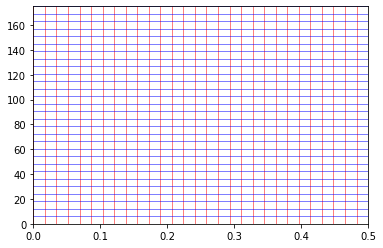

In [49]:
for xc in Vol:
    plt.axvline(x=xc, color='red', linestyle='-', linewidth = .5)

for yc in Spot:
    plt.axhline(y=yc, color='blue', linestyle='-', linewidth = .5)

plt.ylim(min(Spot), max(Spot))
plt.xlim(min(Vol), max(Vol))
plt.show()

In [50]:
(Spot, Vol) = BuildGrid('non-uniform', p_grid, p_option)

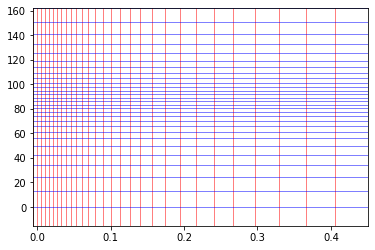

In [51]:
for xc in Vol:
    plt.axvline(x=xc, color='red', linestyle='-', linewidth = .5)

for yc in Spot:
    plt.axhline(y=yc, color='blue', linestyle='-', linewidth = .5)

plt.ylim(min(Spot), max(Spot))
plt.xlim(min(Vol), max(Vol))
plt.show()

### Derivatives Approximations for Non Uniform Grid

$$
\frac{\partial U}{\partial S} (S_i, v_j) =
\left(
\frac{U^n_{i+1,j} − U^n_{i-1,j}}{S_{i+1}−S_{i-1}} \right)
$$

$$
\frac{\partial U}{\partial v} (S_i, v_j) =
\left(
\frac{U^n_{i,j+1} − U^n_{i,j-1}}{v_{j+1}−v_{j-1}} \right)
$$

$$
\frac{\partial^2 U}{\partial S^2} (S_i, v_j) =
\left(
\frac{U^n_{i+1,j} − U^n_{i,j}}{S_{i+1}−S_{i}}
− 
\frac{U^n_{i,j}−U^n_{i−1,j}}{S_{i}−S_{i−1}}
\right)
\frac{1}{S_{i+1}−S_{i}}
$$

$$
\frac{\partial^2 U}{\partial v^2} (S_i, v_j) =
\left(
\frac{U^n_{i,j+1} − U^n_{i,j}}{v_{j+1}−v_{j}}
− 
\frac{U^n_{i,j}−U^n_{i,j−1}}{v_{j}−v_{j−1}}
\right)
\frac{1}{v_{j+1}−v_{j}}
$$

$$
\frac{\partial^2 U}{\partial S \partial v} (S_i, v_j) =
\left(
\frac{U^n_{i+1,j+1} − U^n_{i-1,j+1} - U^n_{i+1,j-1} + U^n_{i-1,j−1}}{(S_{i+1} - S_{i-1})(v_{j+1}−v_{j−1})}
\right)
$$

In [52]:
def HestonExplicitPDE_NU(Si, vi, p_heston, p_option, p_grid):
    
    start = time.time()
    print('program starts...')
    #
    # Number of Steps in Each Dimension
    #
    NS = p_grid['NS']
    NV = p_grid['NV']
    NT = p_grid['NT']
    #
    # Option Features
    #
    Strike = p_option['Strike']
    r      = p_option['r']
    q      = p_option['q']
    #
    # Boundary Values for Stock Price, Volatility, and Maturity
    #
    Smax = p_grid['Smax']
    Tmin = p_grid['Tmin']
    Tmax = p_grid['Tmax']
    #
    # Heston parameters. Note: only kappa, theta, and sigma are needed
    #
    kappa = p_heston['kappa']
    theta = p_heston['theta']
    sigma = p_heston['sigma']
    rho   = p_heston['rho']
    #
    # Building grid
    #
    (Spot, Vol) = BuildGrid('non-uniform', p_grid, p_option)
    
    # Increment for Maturity
    dt = (Tmax - Tmin) / (NT - 1)
    
    # Initialize the 2-D grid with zeros
    U = np.zeros((NS, NV))
    
    # Temporary grid for previous time steps
    u = np.zeros((NS, NV))

    # Boundary condition for Call Option at t = Maturity
    for j in range(NV):
        U[:,j] = np.maximum(Spot - Strike, 0)

    for tt in range(NT):
        # Boundary condition for Smin and Smax
        U[0,:]    = 0
        U[NS-1,:] = np.max(Smax - Strike, 0)
        # Boundary condition for Vmax
        U[:,NV-1] = np.maximum(Spot - Strike, 0)
        # Update the temporary grid u(s,t) with the boundary conditions
        u = U
        # Boundary condition for Vmin.
        # Previous time step values are in the temporary grid u(s,t)
        for ss in range(1, NS-1):
            DerV     = (u[ss, 1] - u[ss, 0]) / (Vol[1] - Vol[0])
            DerS     = (u[ss + 1, 0] - u[ss - 1, 0]) / (Spot[ss + 1] - Spot[ss - 1])
            LHS      = -r * u[ss, 0] + (r - q) * Spot[ss] * DerS + kappa * theta * DerV
            U[ss, 0] = LHS * dt + u[ss, 0]
        # Update the temporary grid u(s,t) with the boundary conditions
        u = U
        # Interior points of the grid (non boundary).
        # As usual previous time step values are in the temporary grid u(s,t)
        for s in range(1, NS - 1):
            for v in range(1, NV - 1):
                DerS = (u[s + 1, v] - u[s - 1, v]) / (Spot[s + 1] - Spot[s - 1])      # Central difference for dU/dS
                DerV = (u[s, v + 1] - u[s, v - 1]) / (Vol[v + 1] - Vol[v - 1])        # Central difference for dU/dV
                DerSS = ((u[s + 1, v] - u[s, v]) / \
                        (Spot[s + 1] - Spot[s]) - (u[s, v] - u[s - 1, v]) / \
                        (Spot[s] - Spot[s - 1])) / (Spot[s + 1] - Spot[s])            # d2U/dS2
                DerVV = ((u[s, v + 1] - u[s, v]) / \
                        (Vol[v + 1] - Vol[v]) - (u[s, v] - u[s, v - 1]) / \
                        (Vol[v] - Vol[v - 1])) / (Vol[v + 1] - Vol[v])                # d2U/dV2
                DerSV = (u[s + 1, v + 1] - u[s - 1, v + 1] - u[s + 1, v - 1] + u[s - 1, v - 1]) / \
                        (Spot[s + 1] - Spot[s - 1]) / (Vol[v + 1] - Vol[v - 1])       # d2U/dSdV
                L = 0.5 * Vol[v] * Spot[s] * Spot[s] * DerSS + rho * sigma * Vol[v] * Spot[s] * DerSV \
                  + 0.5 * sigma * sigma * Vol[v] * DerVV - r * u[s, v] \
                  + (r - q) * Spot[s] * DerS + kappa * (theta - Vol[v]) * DerV
                # The PDE
                U[s, v] = L * dt + u[s, v]
        
    U = U.transpose()        
        
    f = scipy.interpolate.interp2d(Spot, Vol, U)
    end = time.time()
    print('program ends...')
    return (f(Si, vi), end - start)    


In [53]:
def HestonExplicitPDE(Si, vi, p_heston, p_option, p_grid):
    '''
    ' Finite differences for the Heston PDE for a European Call
    ' Reference:
    ' In 'T Hout and Foulon "ADI Finite Difference Schemes for Option Pricing in the Heston Model with Correlation" 
    ' Int J of Num Analysis and Modeling, 2010.
    ' INPUTS
    '    params     = 6x1 vector of Heston parameters
    '    Strike     = Strike price
    '    r          = risk free rate
    '    q          = Dividend yield
    '    Smax, Smin = Max and Min values of stock price
    '    Vmax, Vmin = Max and Min values of volatility
    '    Tmax, Tmin = Max and Min values of maturity
    '    NS, NV, NT = Number of points on stock price, volatility, and maturity grids
    '    GridType   = Type of Grid ("Uniform" or "NonUniform")
    '    Si         = Value of Spot price at which to interpolate on U(S,V)
    '    Vi         = Value of Volatility at which to interpolate on U(S,V)
    ' OUTPUT
    '    U(Si,Vi)   = Interpolated value of U(S,V) and points (Si,Vi)
    '''
    start = time.time()
    print('program starts...')
    #
    # Number of Steps in Each Dimension
    #
    NS = p_grid['NS']
    NV = p_grid['NV']
    NT = p_grid['NT']
    #
    # Option Features
    #
    Strike = p_option['Strike']
    r      = p_option['r']
    q      = p_option['q']
    #
    # Boundary Values for Stock Price, Volatility, and Maturity
    #
    Smin = p_grid['Smin']
    Smax = p_grid['Smax']
    Vmin = p_grid['Vmin'] 
    Vmax = p_grid['Vmax']
    Tmin = p_grid['Tmin']
    Tmax = p_grid['Tmax']
    # Heston parameters. Note: only kappa, theta, and sigma are needed
    kappa = p_heston['kappa']
    theta = p_heston['theta']
    sigma = p_heston['sigma']
    # Increment for Stock Price, Volatility, and Maturity
    ds = (Smax - Smin) / (NS - 1)
    dv = (Vmax - Vmin) / (NV - 1)
    dt = (Tmax - Tmin) / (NT - 1)
    # Building a Uniform Grid
    Mat  = np.arange(Tmin, Tmax + dt, dt)
    Spot = np.arange(Smin, Smax + ds, ds)
    Vol  = np.arange(Vmin, Vmax + dv, dv)  
    # Make sure the array have the right dimension
    Mat  = Mat[:NT]
    Spot = Spot[:NS]
    Vol  = Vol[:NV]
    
    # Initialize the 2-D grid with zeros
    U = np.zeros((NS, NV))
    
    # Temporary grid for previous time steps
    u = np.zeros((NS, NV))
    
    # Boundary condition for Call Option at t = Maturity
    for j in range(NV):
        U[:,j] = np.maximum(Spot - Strike, 0)
    
    # loop on maturity
    c1 = (1 - r * dt - kappa * theta * dt / dv)
    c2 = dt * 0.5 * (r - q)/ds
    c3 = kappa * theta * (dt/dv)
    for tt in range(NT):
        # Boundary condition for Smin and Smax
        U[0,:]    = 0
        U[NS-1,:] = np.max(Smax - Strike, 0)
        # Boundary condition for Vmax
        U[:,NV-1] = np.maximum(Spot - Strike, 0)
        # Update the temporary grid u(s,t) with the boundary conditions
        u = U
        # Boundary condition for Vmin.
        # Previous time step values are in the temporary grid u(s,t)
           
        U[1:NS-2,0] = c1 * u[1:NS-2,0] \
                    + c2 * Spot[1:NS-2] * (u[2:NS-1, 0] - u[0:NS-3,0]) \
                    + c3 * u[1:NS-2,1]  
        
        # Update the temporary grid u(s,t) with the boundary conditions
        u = U
        # Interior points of the grid (non boundary).
        # As usual previous time step values are in the temporary grid u(s,t)
        for i in range(1, NS - 1):
            for j in range(1, NV - 1):
                C1 = (1 - dt * i * i * j * dv - sigma * sigma * j * dt / dv - r * dt)
                C2 = (0.5 * dt * i * i * j * dv - 0.5 * dt * (r - q) * i)
                C3 = (0.5 * dt * i * i * j * dv + 0.5 * dt * (r - q) * i)
                C4 = (0.5 * dt * sigma * sigma * j / dv - 0.5 * dt * kappa * (theta - j * dv) / dv)
                C5 = (0.5 * dt * sigma * sigma * j / dv + 0.5 * dt * kappa * (theta - j * dv) / dv)
                C6 = 0.25 * dt * sigma * i * j
                # The PDE
                U[i, j] = C1 * u[i, j] + C2 * u[i - 1, j] + C3 * u[i + 1, j] \
                       + C4 * u[i, j - 1] + C5 * u[i, j + 1] \
                       + C6 * (u[i + 1, j + 1] + u[i - 1, j - 1] - u[i - 1, j + 1] - u[i + 1, j - 1])
                      
    U = U.transpose()        
        
    f = scipy.interpolate.interp2d(Spot, Vol, U)
    end = time.time()
    print('program ends...')
    return (f(Si, vi), end - start)    

In [54]:
    # Heston Parameters
    p_heston = {'kappa' :kappa
               ,'theta' :theta
               ,'sigma' :sigma
               ,'v0'    :v0
               ,'rho'   :rho
               ,'lambda':0.00000}
    # Option features
    p_option = {'Strike':K
               ,'r'     :r
               ,'q'     :q
               }
    # Grid parameters
    p_grid   = {'NS':30
               ,'NV':30
               ,'NT':1500
               ,'Smin':0
               ,'Smax':2 * p_option['Strike']
               ,'Vmin':0
               ,'Vmax':0.5
               ,'Tmin':0
               ,'Tmax':tau
               }    
    
    Si = S
    vi = p_heston['v0']
    
    call_price_1 =  HestonExplicitPDE(Si, vi, p_heston, p_option, p_grid)
    call_price_2 =  HestonExplicitPDE_NU(Si, vi, p_heston, p_option, p_grid)
    
    print(call_price_1[0], call_price_1[1])
    print(call_price_2[0], call_price_2[1])


program starts...
program ends...
program starts...
program ends...
[4.27674443] 9.961606979370117
[4.04314205] 24.208297967910767


# References #

*Rouah F. D.*, **The Heston Model and its Extensions in VBA**, Wiley Financial Series

*Rouah F. D.*, **The Heston Model and its Extensions in Matlab and C#**, Wiley Financial Series
